# Building Point Cloud — Horizontal Level Detector (XY & YZ)

Этот ноутбук строит проекции XY и YZ, подготавливает тепловые карты плотности,
выделяет горизонтальные уровни (этажи, подоконники, перемычки, карнизы),
и визуализирует всё по шагам. Каждый шаг либо рисует график, либо печатает логи.

**Как пользоваться**
1. Укажи путь к своему `.obj` в переменной `IN_OBJ_PATH` ниже.
2. Запусти ячейки по порядку. Если файла нет, сработает синтетическая демо-сцена.
3. Основные параметры подгоняются в секции `CONFIG`.


## Imports & Config

In [1]:
# %%
import os
from dataclasses import dataclass
from typing import Tuple, List, Dict
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter, binary_closing, binary_opening, sobel
from scipy.signal import find_peaks
import pandas as pd

# --- Path to your OBJ ---
IN_OBJ_PATH = "input/Hitem3D_Model_Generator/model.obj"  # <- поменяй на свой путь

# --- CONFIG ---
GRID_RES_XY = (2048, 1024)   # (W,H) сетка гистограммы для XY
GRID_RES_YZ = (2048, 1024)   # (W,H) сетка гистограммы для YZ

SMOOTH_SIGMA = 1.5           # сглаживание тепловой карты
MORPH_LEN_PX = 31            # длина структурного элемента (горизонтально) для закрытия/открытия
EDGE_BAND_PX = 3             # полуширина полосы вокруг уровня для оценки покрытия
PEAK_PROM = 0.05             # относительная выраженность пиков производной (0..1)
PEAK_DIST = 8                # минимальная дистанция между пиками (пикселы по вертикали)
MERGE_TOL_PX = 6             # слияние близких уровней (px)
MIN_COVERAGE = 0.25          # фильтр минимального покрытия линии по ширине фасада

# Демо-режим, если OBJ нет
USE_SYNTHETIC_IF_MISSING = True
np.set_printoptions(suppress=True, precision=4)
print('CONFIG loaded.')


CONFIG loaded.


## OBJ reader + synthetic fallback

In [2]:
# %%
def read_obj_file(file_path):
    vertices = []
    faces = []
    if not os.path.isfile(file_path):
        print(f"Warning: .obj not found: {os.path.abspath(file_path)}")
        return vertices, faces
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('v '):
                parts = line.split()
                try:
                    x, y, z = map(float, parts[1:4])
                    vertices.append((x, y, z))
                except ValueError:
                    pass
            elif line.startswith('f '):
                parts = line.split()
                face = []
                for idx in parts[1:]:
                    if '/' in idx:
                        v_idx = idx.split('/')[0]
                    else:
                        v_idx = idx
                    try:
                        face.append(int(v_idx))
                    except ValueError:
                        pass
                if len(face) >= 3:
                    faces.append(face)
    return vertices, faces

def make_synthetic_building(n=250_000, floors=7, width=1.2, depth=0.6, height_per=0.3,
                            window_bands=True, balcony_levels=(2,5)):
    """Простейшая синтетика: прямой фасад с этажами и оконными лентами."""
    xs = (np.random.rand(n) - 0.5) * width
    ys = np.random.rand(n) * floors * height_per
    zs = (np.random.rand(n) - 0.5) * depth
    pts = np.stack([xs, ys, zs], axis=1)

    # усилить плотность вокруг перекрытий этажей:
    for k in range(floors + 1):
        y0 = k * height_per
        mask = np.abs(pts[:,1] - y0) < 0.004
        pts[mask, 0] *= 0.2

    # оконные ленты
    if window_bands:
        for k in range(floors):
            y_band = k*height_per + 0.12
            m = np.abs(pts[:,1] - y_band) < 0.003
            pts[m, 2] *= 0.4

    # балконы
    for k in balcony_levels:
        yb = k*height_per + 0.15
        m = np.abs(pts[:,1] - yb) < 0.004
        pts[m, 0] += 0.2 * (0.5 - np.random.rand(m.sum()))
    return pts

verts, faces = read_obj_file(IN_OBJ_PATH)
if len(verts) == 0 and USE_SYNTHETIC_IF_MISSING:
    points = make_synthetic_building()
    print('Using synthetic demo cloud:', points.shape)
else:
    points = np.array(verts, dtype=float)
    print('Loaded OBJ vertices:', points.shape)
print('First rows:\n', points[:5])


Loaded OBJ vertices: (1050144, 3)
First rows:
 [[-0.5855 -0.2052 -0.0563]
 [-0.5854 -0.2051 -0.062 ]
 [-0.5853 -0.2049 -0.0564]
 [-0.5853 -0.2052 -0.0518]
 [-0.5852 -0.2056 -0.057 ]]


## Quick scatter projections (XY, XZ, YZ)

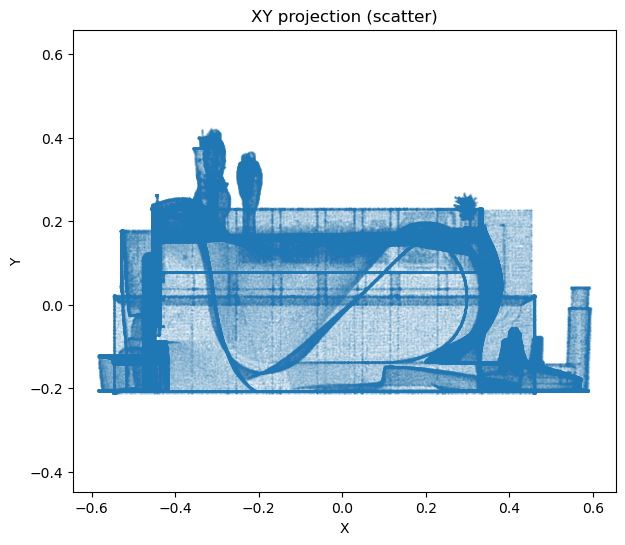

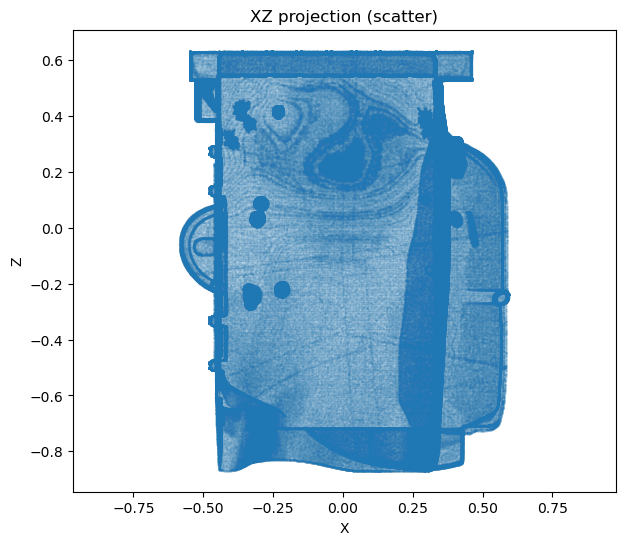

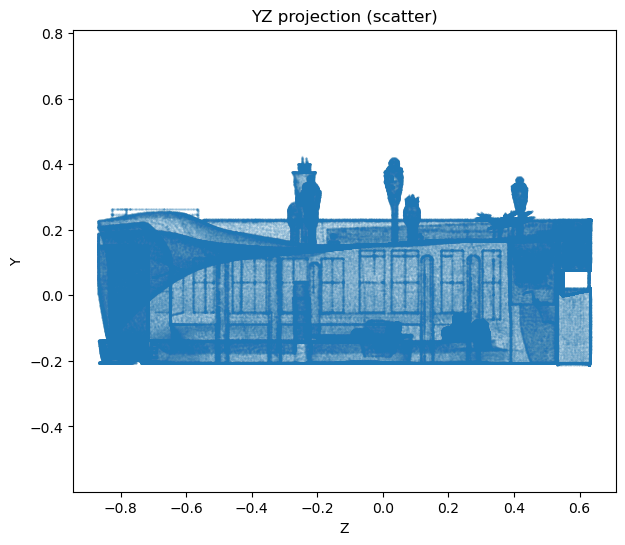

In [3]:
# %%
import matplotlib.pyplot as plt

def scatter_projection(points, axes=(0,1), title='Projection'):
    a, b = axes
    plt.figure(figsize=(7,6))
    plt.scatter(points[:, a], points[:, b], s=0.2, alpha=0.1)
    plt.xlabel(['X','Y','Z'][a])
    plt.ylabel(['X','Y','Z'][b])
    plt.title(title)
    plt.axis('equal')
    plt.show()

scatter_projection(points, (0,1), 'XY projection (scatter)')
scatter_projection(points, (0,2), 'XZ projection (scatter)')
scatter_projection(points, (2,1), 'YZ projection (scatter)')


## Density grids (histogram2d) for XY and YZ

In [4]:
# sanity-check
print("points shape:", points.shape)
finite_mask = np.isfinite(points).all(axis=1)
print("finite rows:", finite_mask.sum(), "/", len(points))
print("has NaN:", np.isnan(points).any(), "has Inf:", np.isinf(points).any())

points shape: (1050144, 3)
finite rows: 1050144 / 1050144
has NaN: False has Inf: False


[make_projection_grid] bins: (1024, 2048), nonzero bins: 379076/2097152, max=507, range_a=(-0.547,0.579), range_b=(-0.207,0.378)
[make_projection_grid] bins: (1024, 2048), nonzero bins: 437679/2097152, max=671, range_a=(-0.858,0.631), range_b=(-0.207,0.378)


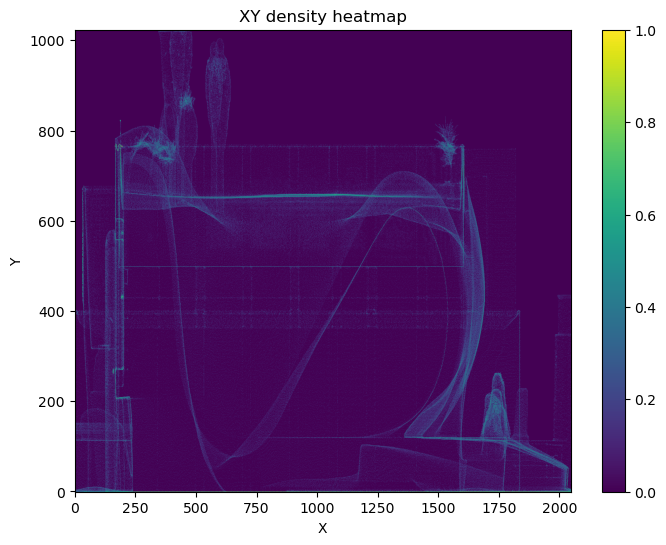

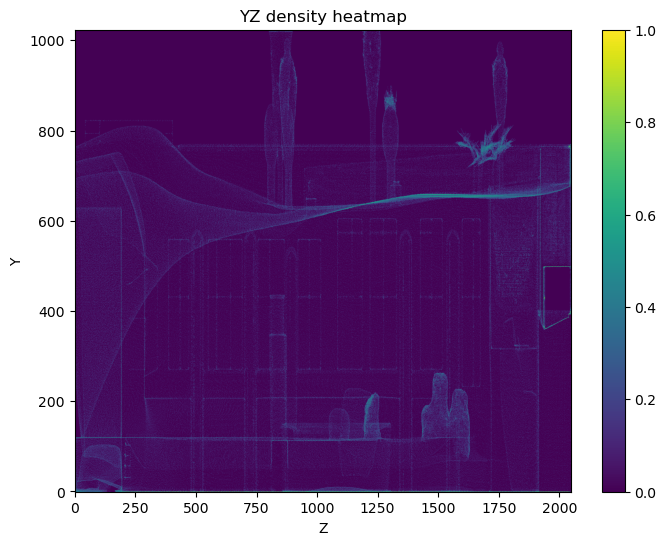

In [5]:
def make_projection_grid(points_xyz: np.ndarray,
                         axes: Tuple[int,int],
                         resolution=(2048,1024),
                         bounds=None,
                         log_scale=True):
    A, B = axes
    w, h = resolution

    a_full = points_xyz[:, A]
    b_full = points_xyz[:, B]

    # ❶ Удаляем NaN/Inf
    mask = np.isfinite(a_full) & np.isfinite(b_full)
    a = a_full[mask]
    b = b_full[mask]
    if a.size == 0:
        raise ValueError("No finite points for selected axes.")

    # ❷ Диапазоны по перцентилям БЕЗ NaN
    if bounds is None:
        a_min, a_max = np.nanpercentile(a, [0.5, 99.5])
        b_min, b_max = np.nanpercentile(b, [0.5, 99.5])
    else:
        (a_min, a_max), (b_min, b_max) = bounds

    # Перестраховка: если границы схлопнулись — чуть расширим
    if not np.isfinite([a_min, a_max, b_min, b_max]).all():
        raise ValueError("Invalid range: NaN in (a_min, a_max, b_min, b_max)")
    if a_max <= a_min:
        eps = 1e-6 or (np.nanstd(a) * 1e-3)
        a_max = a_min + eps
    if b_max <= b_min:
        eps = 1e-6 or (np.nanstd(b) * 1e-3)
        b_max = b_min + eps

    # ❸ Само бинование (x=b, y=a, чтобы первая ось = вертикаль (Y))
    H, b_edges, a_edges = np.histogram2d(b, a, bins=[h, w],
                                         range=[[b_min, b_max], [a_min, a_max]])
    nonzero = int(np.count_nonzero(H))
    print(f"[make_projection_grid] bins: {H.shape}, nonzero bins: {nonzero}/{H.size}, "
          f"max={H.max():.0f}, range_a=({a_min:.3f},{a_max:.3f}), range_b=({b_min:.3f},{b_max:.3f})")

    # ❹ Нормализация: лог-масштаб хорошо «вытягивает» слабо заполненные полосы
    H = H.astype(np.float32)
    if H.max() > 0:
        if log_scale:
            H = np.log1p(H)      # log(1 + count)
        H /= H.max()

    return {
        'img': H,                # (h, w)
        'a_edges': a_edges,      # горизонтальная ось (X или Z)
        'b_edges': b_edges,      # вертикальная ось (Y)
        'bounds': ((a_min, a_max), (b_min, b_max)),
        'axes': axes
    }
proj_xy = make_projection_grid(points, (0,1), GRID_RES_XY)
proj_yz = make_projection_grid(points, (2,1), GRID_RES_YZ)

for name, P in [('XY', proj_xy), ('YZ', proj_yz)]:
    plt.figure(figsize=(8,6))
    plt.imshow(P['img'], origin='lower', aspect='auto')
    plt.title(f'{name} density heatmap')
    plt.xlabel('X' if name=='XY' else 'Z')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()

In [6]:
# %% [tuning]

import ipywidgets as W
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt

def _overlay(img, peaks, title):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.imshow(img, origin='lower', aspect='auto')
    for y in peaks:
        ax.axhline(y, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel('X' if img.shape[1] == proj_xy['img'].shape[1] else 'Z')
    ax.set_ylabel('Y')
    plt.show()

def _tune(sigma, morph, prom, dist, ymin, ymax):
    # берём копии карт, опционально подрезаем по высоте (чтоб убрать землю/артефакты)
    img_xy = proj_xy['img'].copy()
    img_yz = proj_yz['img'].copy()

    def _cut(img):
        h = img.shape[0]
        y0 = int(h * ymin/100)
        y1 = int(h * ymax/100)
        if y0>0: img[:y0,:] = 0
        if y1<h: img[y1:,:] = 0
        return img

    img_xy = _cut(img_xy); img_yz = _cut(img_yz)

    gxy, bxy, exy = preprocess(img_xy, sigma=sigma, morph_len_px=morph)
    gyz, byz, eyz = preprocess(img_yz, sigma=sigma, morph_len_px=morph)

    acc_xy, der_xy, pk_xy, _ = detect_levels_from_edges(exy, prominence=prom, distance=dist)
    acc_yz, der_yz, pk_yz, _ = detect_levels_from_edges(eyz, prominence=prom, distance=dist)

    clear_output(wait=True)
    _overlay(img_xy, pk_xy, f'XY heatmap + {len(pk_xy)} lines')
    _overlay(img_yz, pk_yz, f'YZ heatmap + {len(pk_yz)} lines')

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].plot(acc_xy); ax[0].plot(np.abs(np.gradient(acc_xy)))
    if len(pk_xy): ax[0].scatter(pk_xy, np.abs(np.gradient(acc_xy))[pk_xy], marker='x')
    ax[0].set_title('XY: row_acc & |d/dy|'); ax[0].set_xlabel('row (y px)')
    ax[1].plot(acc_yz); ax[1].plot(np.abs(np.gradient(acc_yz)))
    if len(pk_yz): ax[1].scatter(pk_yz, np.abs(np.gradient(acc_yz))[pk_yz], marker='x')
    ax[1].set_title('YZ: row_acc & |d/dy|'); ax[1].set_xlabel('row (y px)')
    plt.show()

    print(f'Selected XY lines (px): {list(pk_xy)}')
    print(f'Selected YZ lines (px): {list(pk_yz)}')

ui = W.interactive_output(
    _tune,
    {
        'sigma': W.FloatSlider(value=2.0, min=0.8, max=4.0, step=0.2, description='sigma'),
        'morph': W.IntSlider(value=61, min=0, max=151, step=10, description='morph_len'),
        'prom':  W.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.005, description='prominence'),
        'dist':  W.IntSlider(value=12, min=2, max=40, step=2, description='peak_dist'),
        'ymin':  W.IntSlider(value=0, min=0, max=40, step=1, description='cut Y% low'),
        'ymax':  W.IntSlider(value=100, min=60, max=100, step=1, description='cut Y% high'),
    }
)
display(ui)

Output()

## Preprocess: smooth, morphology, vertical edges (per projection)

In [ ]:
# %%
def preprocess(img: np.ndarray, sigma=1.5, morph_len_px=31):
    g = gaussian_filter(img, sigma=sigma)
    thr = max(0.05, np.percentile(g, 90))
    bin_map = (g > thr).astype(np.uint8)
    if morph_len_px > 0:
        se = np.ones((1, morph_len_px), np.uint8)
        # scipy binary_* ожидает bool
        b = bin_map.astype(bool)
        b = binary_closing(b, structure=se)
        b = binary_opening(b, structure=se)
        bin_map = b.astype(np.uint8)
    # вертикальный градиент (ось=0, т.к. img[h,w], h — Y)
    edges_v = np.abs(sobel(g, axis=0))
    if edges_v.max() > 0: edges_v /= edges_v.max()
    return g, bin_map, edges_v

def show_preproc(name, img, g, bmap, edges):
    plt.figure(figsize=(8,6)); plt.imshow(img, origin='lower', aspect='auto'); plt.title(f'{name}: raw density'); plt.colorbar(); plt.show()
    plt.figure(figsize=(8,6)); plt.imshow(g, origin='lower', aspect='auto'); plt.title(f'{name}: smoothed'); plt.colorbar(); plt.show()
    plt.figure(figsize=(8,6)); plt.imshow(bmap, origin='lower', aspect='auto'); plt.title(f'{name}: binary after morphology'); plt.colorbar(); plt.show()
    plt.figure(figsize=(8,6)); plt.imshow(edges, origin='lower', aspect='auto'); plt.title(f'{name}: vertical edges (Sobel-y)'); plt.colorbar(); plt.show()

g_xy, b_xy, e_xy = preprocess(proj_xy['img'], SMOOTH_SIGMA, MORPH_LEN_PX)
g_yz, b_yz, e_yz = preprocess(proj_yz['img'], SMOOTH_SIGMA, MORPH_LEN_PX)

show_preproc('XY', proj_xy['img'], g_xy, b_xy, e_xy)
show_preproc('YZ', proj_yz['img'], g_yz, b_yz, e_yz)
print('Preprocess done.')


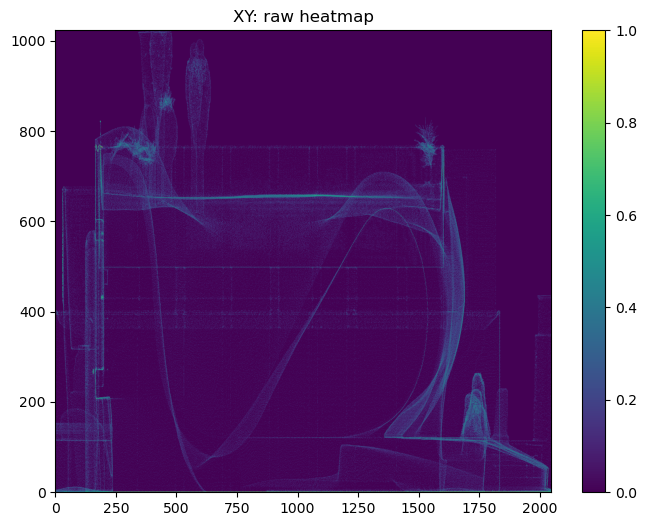

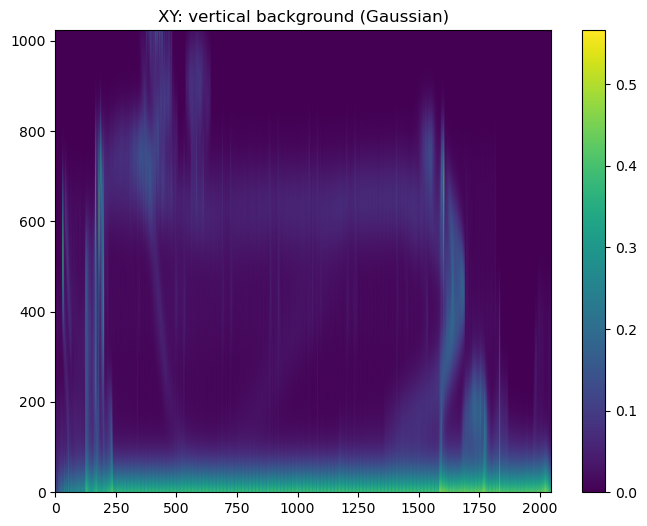

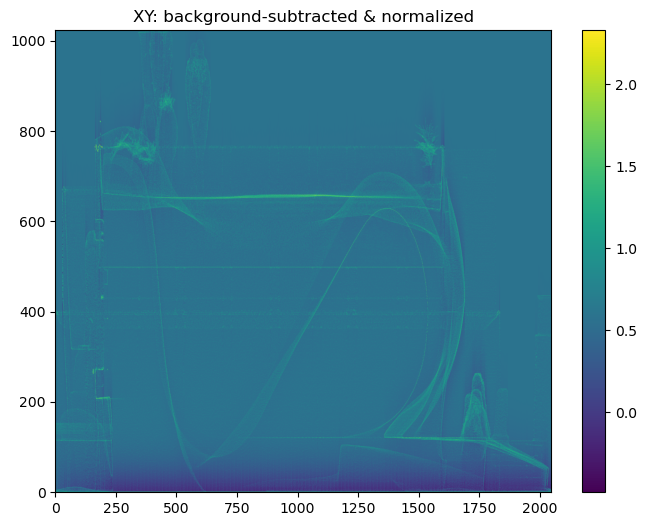

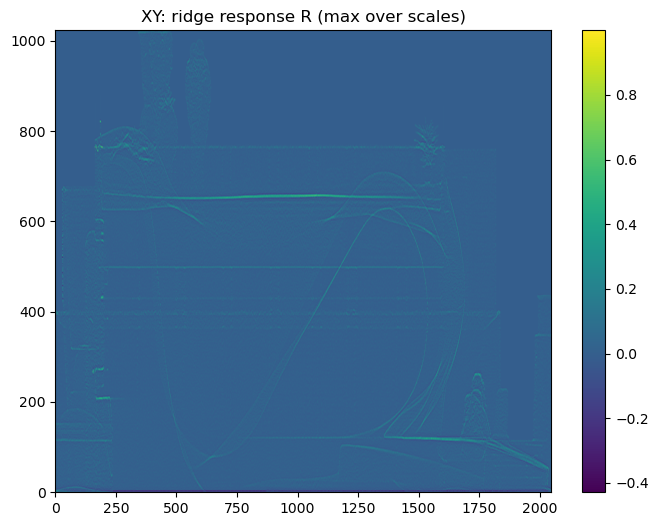

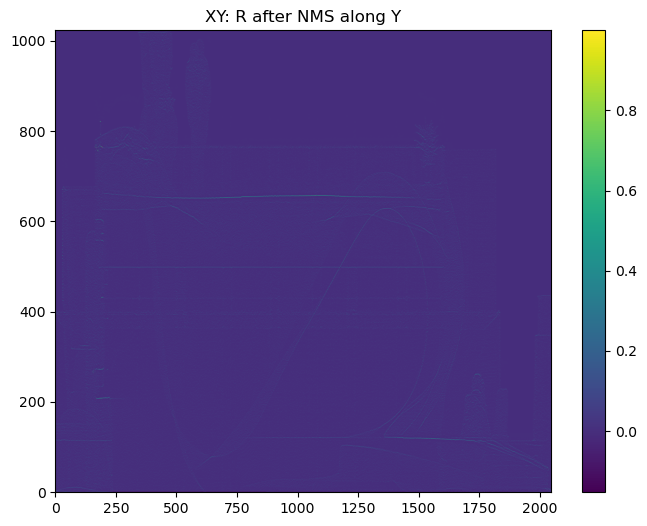

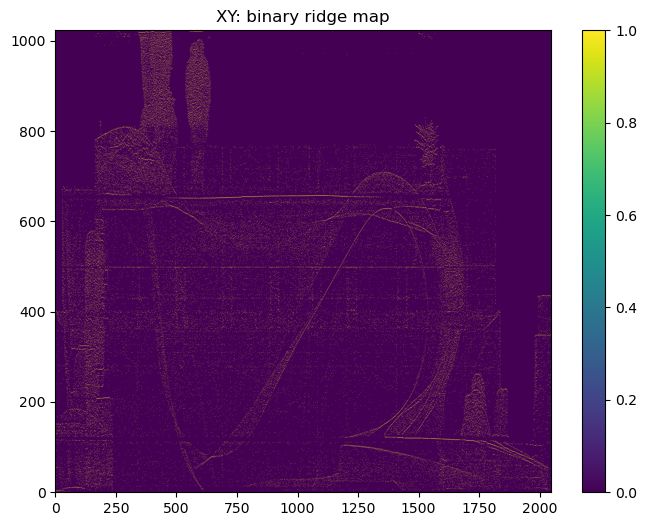

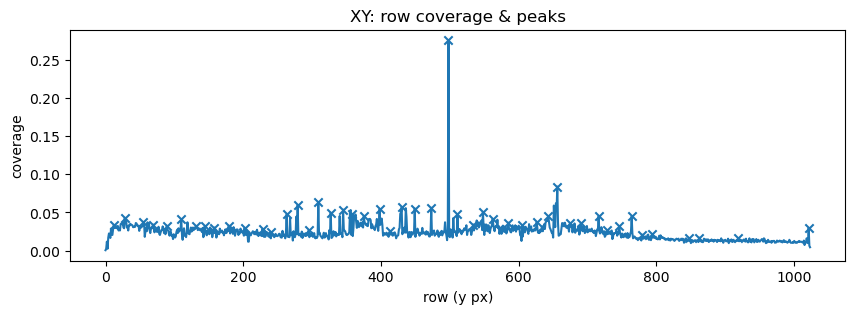

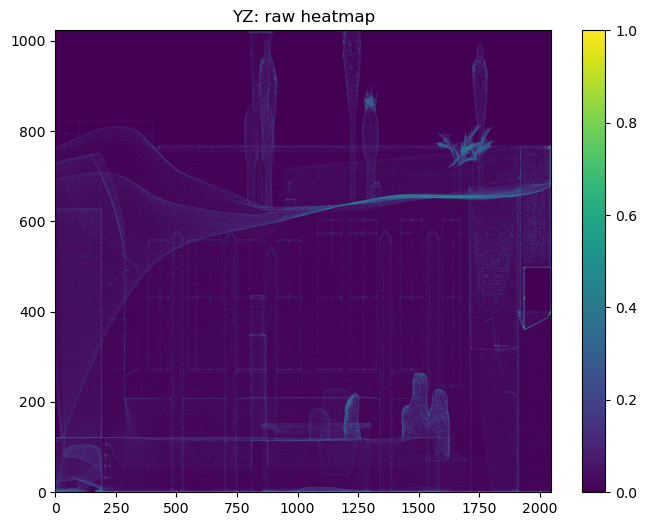

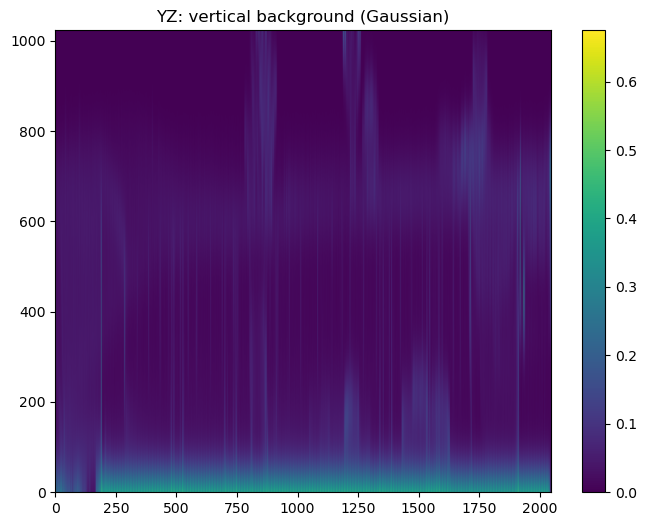

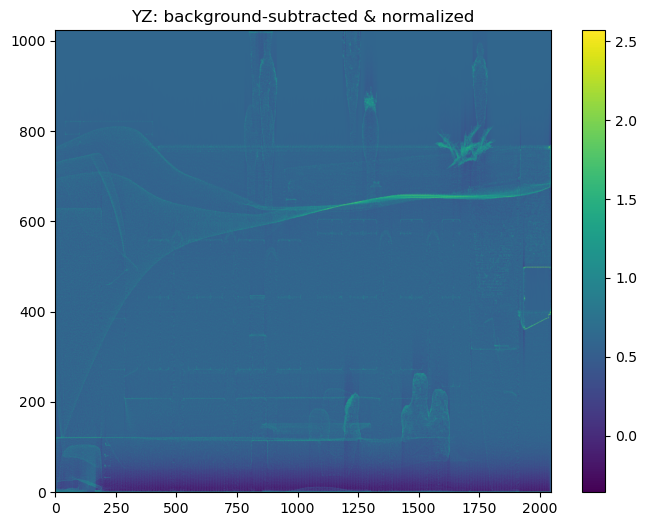

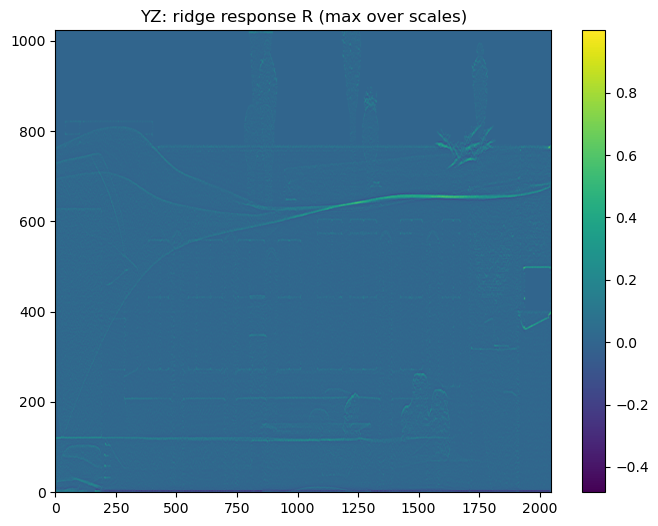

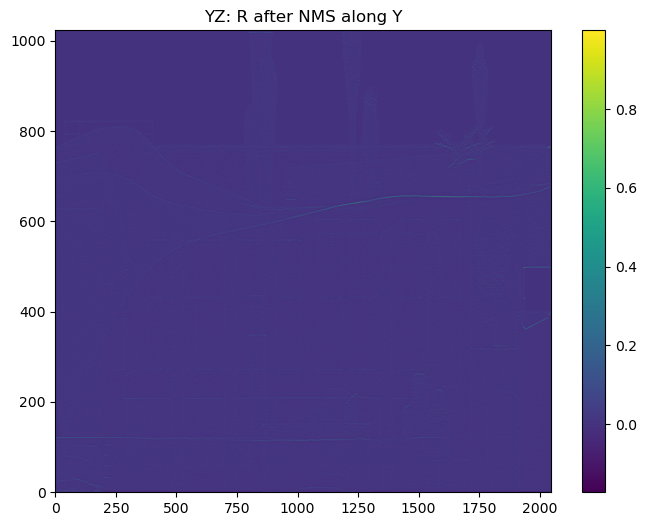

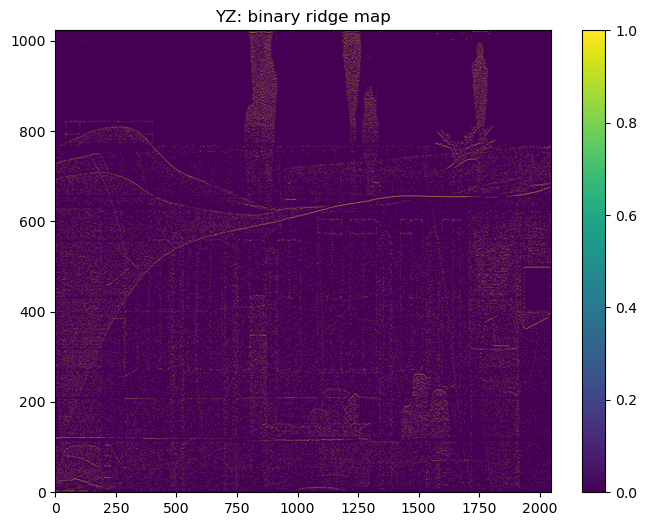

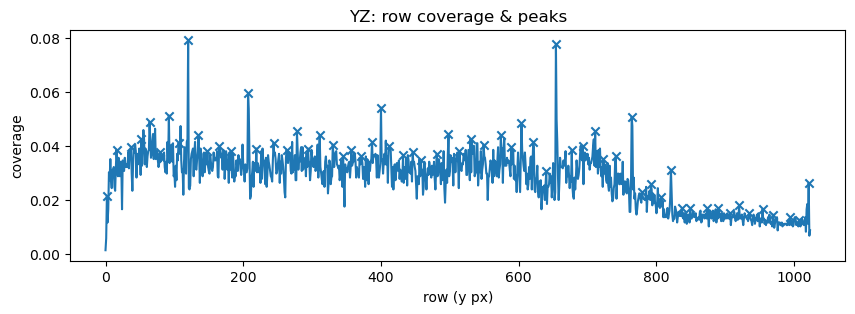

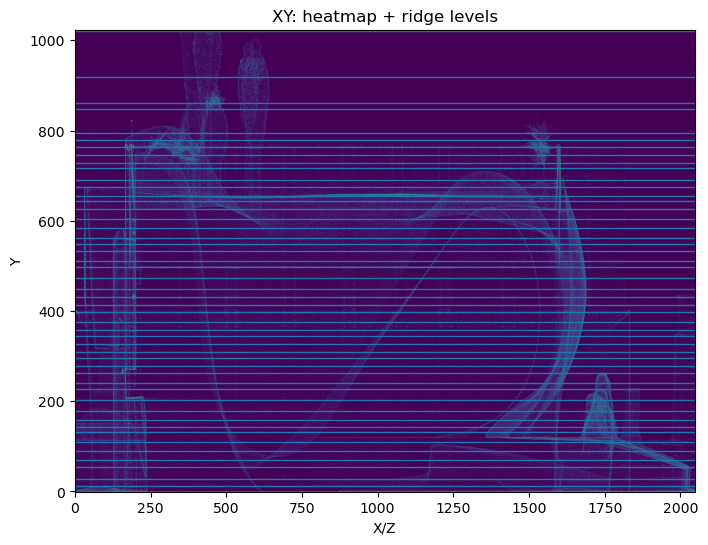

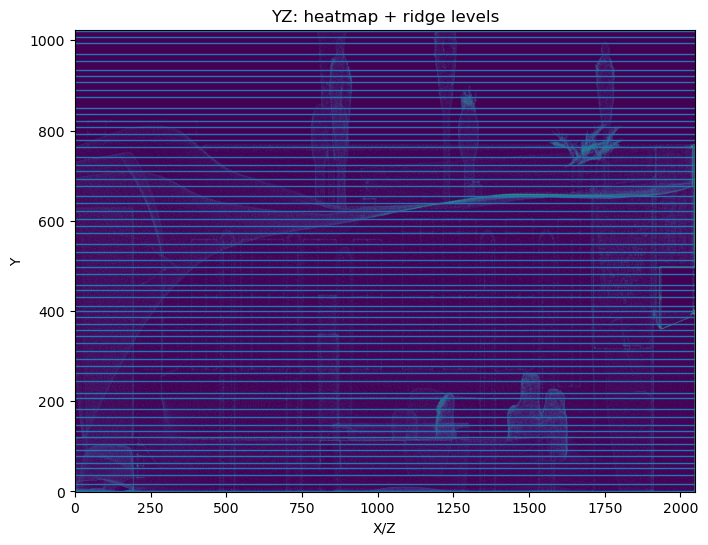

XY y_world: [np.float64(-0.1995), np.float64(-0.1904), np.float64(-0.1749), np.float64(-0.1669), np.float64(-0.1555), np.float64(-0.1435), np.float64(-0.1315), np.float64(-0.1241), np.float64(-0.1161), np.float64(-0.1041), np.float64(-0.091), np.float64(-0.0761), np.float64(-0.0687), np.float64(-0.0561), np.float64(-0.047), np.float64(-0.0378), np.float64(-0.0298), np.float64(-0.0196), np.float64(-0.0093), np.float64(-0.0019), np.float64(0.0079), np.float64(0.021), np.float64(0.0296), np.float64(0.0393), np.float64(0.0501), np.float64(0.0638), np.float64(0.0781), np.float64(0.0855), np.float64(0.0987), np.float64(0.1067), np.float64(0.1147), np.float64(0.1278), np.float64(0.1392), np.float64(0.1512), np.float64(0.1609), np.float64(0.1684), np.float64(0.1792), np.float64(0.1878), np.float64(0.2026), np.float64(0.2095), np.float64(0.2198), np.float64(0.2301), np.float64(0.2386), np.float64(0.2472), np.float64(0.2775), np.float64(0.286), np.float64(0.3186), np.float64(0.3769)]
YZ y_world:

: 

In [ ]:
# %% RIDGE MODE (замена бинарной морфологии)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

def vertical_background_normalize(img, sigma_bg=20):
    """
    Убираем медленно меняющийся фон по оси Y (вертикально), оставляя тонкие полосы.
    """
    bg = gaussian_filter1d(img, sigma=sigma_bg, axis=0, mode='nearest')
    norm = img - bg
    # приведение к [0,1] для визуализаций
    mn, mx = np.percentile(norm, [1, 99])
    if mx > mn:
        norm = (norm - mn) / (mx - mn)
    return norm, bg

def ridge_response_y(img, scales=(1.0, 2.0, 3.0)):
    """
    Multi-scale риджи по оси Y: R = max_s ( - s^2 * d2/dy2 ( G_y(img, s) ) ).
    Для «светлых» линий используем минус вторую производную (выпуклость вниз).
    """
    Rs = []
    D1s = []
    for s in scales:
        L  = gaussian_filter1d(img, sigma=s, axis=0, mode='nearest')
        D1 = np.gradient(L, axis=0)
        D2 = np.gradient(D1, axis=0)
        R  = -(s**2) * D2
        Rs.append(R)
        D1s.append(D1)
    Rmax = Rs[0].copy()
    D1_at_max = D1s[0].copy()
    for R, D1 in zip(Rs[1:], D1s[1:]):
        swap = R > Rmax
        Rmax[swap] = R[swap]
        D1_at_max[swap] = D1[swap]  # градиент на «лучшем» масштабе
    # нормируем для удобства порогов/картинок
    Rmax = Rmax / (np.max(Rmax) + 1e-9)
    return Rmax, D1_at_max

def nms_along_y(resp):
    """
    Простая NMS по вертикали: оставляем локальные максимумы по оси Y.
    """
    up   = np.pad(resp, ((1,0),(0,0)), mode='edge')[:-1]
    down = np.pad(resp, ((0,1),(0,0)), mode='edge')[1:]
    keep = (resp >= up) & (resp >= down)
    return resp * keep

def binarize_ridges(resp_nms, d1_at_max, slope_tol=0.05, row_percentile=99, frac=0.6):
    """
    Порог по строкам (адаптивный): пиксель — ридж, если
      - локальный максимум по Y,
      - |dI/dy| в центре маленький (центр линии),
      - отклик выше доли перцентиля по строке.
    """
    H, W = resp_nms.shape
    thr_row = np.percentile(resp_nms, row_percentile, axis=1, keepdims=True)  # (H,1)
    thr = thr_row * frac
    mask = (resp_nms > thr) & (np.abs(d1_at_max) < slope_tol)
    return mask.astype(np.uint8)

def accumulate_rows(bin_ridges):
    """
    Считаем «покрытие» по каждой строке: доля столбцов, где обнаружен ридж.
    """
    cover = bin_ridges.mean(axis=1)  # (H,)
    return cover

def detect_levels_ridge(img,
                        sigma_bg=60,
                        scales=(1.0, 2.0, 3.0),
                        slope_tol=0.05,
                        row_percentile=99,
                        frac=0.7,
                        peak_distance=10,
                        peak_prom=0.02):
    # 1) нормализация фона
    norm, bg = vertical_background_normalize(img, sigma_bg=sigma_bg)
    # 2) ридж-отклик
    R, D1 = ridge_response_y(norm, scales=scales)
    # 3) NMS по Y
    Rnms = nms_along_y(R)
    # 4) бинаризация риджей
    ridges = binarize_ridges(Rnms, D1, slope_tol=slope_tol,
                              row_percentile=row_percentile, frac=frac)
    # 5) аккумулируем по строкам и ищем пики (уровни)
    cover = accumulate_rows(ridges)
    peaks, _ = find_peaks(cover, distance=peak_distance,
                          prominence=peak_prom*np.max(cover) if cover.size else 0.0)
    return {
        "norm": norm, "bg": bg,
        "R": R, "Rnms": Rnms, "ridges": ridges,
        "cover": cover, "peaks": peaks
    }
# %% VIS
def show_ridge_pipeline(name, img, res):
    norm, bg = res["norm"], res["bg"]
    R, Rnms, ridges = res["R"], res["Rnms"], res["ridges"]
    cover, peaks = res["cover"], res["peaks"]

    plt.figure(figsize=(8,6)); plt.imshow(img, origin='lower', aspect='auto')
    plt.title(f'{name}: raw heatmap'); plt.colorbar(); plt.show()

    plt.figure(figsize=(8,6)); plt.imshow(bg, origin='lower', aspect='auto')
    plt.title(f'{name}: vertical background (Gaussian)'); plt.colorbar(); plt.show()

    plt.figure(figsize=(8,6)); plt.imshow(norm, origin='lower', aspect='auto')
    plt.title(f'{name}: background-subtracted & normalized'); plt.colorbar(); plt.show()

    plt.figure(figsize=(8,6)); plt.imshow(R, origin='lower', aspect='auto')
    plt.title(f'{name}: ridge response R (max over scales)'); plt.colorbar(); plt.show()

    plt.figure(figsize=(8,6)); plt.imshow(Rnms, origin='lower', aspect='auto')
    plt.title(f'{name}: R after NMS along Y'); plt.colorbar(); plt.show()

    plt.figure(figsize=(8,6)); plt.imshow(ridges, origin='lower', aspect='auto')
    plt.title(f'{name}: binary ridge map'); plt.colorbar(); plt.show()

    plt.figure(figsize=(10,3)); plt.plot(cover); 
    if len(peaks): plt.scatter(peaks, cover[peaks], marker='x')
    plt.title(f'{name}: row coverage & peaks'); plt.xlabel('row (y px)'); plt.ylabel('coverage'); plt.show()

def overlay_levels_on_img(img, peaks, title='overlay'):
    plt.figure(figsize=(8,6))
    plt.imshow(img, origin='lower', aspect='auto')
    for y in peaks:
        plt.axhline(y, linewidth=1)
    plt.title(title); plt.xlabel('X/Z'); plt.ylabel('Y'); plt.show()

# %% RUN RIDGE MODE
# Подстрой под свой датасет (по твоим скринам часто хорошо работают):
params = dict(
    sigma_bg=60,               # 20–60: насколько грубо снимаем фон
    scales=(1.0, 2.0, 3.0),    # толщина линии (в px). Можно добавить 4.5, если полосы толще
    slope_tol=0.06,            # центр линии ~ нулевой градиент по Y
    row_percentile=99, frac=0.7,  # адаптивный порог по строке
    peak_distance=12, peak_prom=0.02
)

res_xy = detect_levels_ridge(proj_xy['img'], **params)
res_yz = detect_levels_ridge(proj_yz['img'], **params)

show_ridge_pipeline('XY', proj_xy['img'], res_xy)
show_ridge_pipeline('YZ', proj_yz['img'], res_yz)

overlay_levels_on_img(proj_xy['img'], res_xy['peaks'], 'XY: heatmap + ridge levels')
overlay_levels_on_img(proj_yz['img'], res_yz['peaks'], 'YZ: heatmap + ridge levels')

# Перевод индексов строк в мировые Y:
def peaks_to_world_y(peaks_px, b_edges):
    ys = []
    for p in peaks_px:
        p = int(np.clip(p, 0, len(b_edges)-2))
        ys.append(0.5 * (b_edges[p] + b_edges[p+1]))
    return ys

y_levels_xy = peaks_to_world_y(res_xy['peaks'], proj_xy['b_edges'])
y_levels_yz = peaks_to_world_y(res_yz['peaks'], proj_yz['b_edges'])
print('XY y_world:', [round(v, 4) for v in y_levels_xy])
print('YZ y_world:', [round(v, 4) for v in y_levels_yz])

## Row accumulator & peak detection ("Hough θ≈0" approximation)

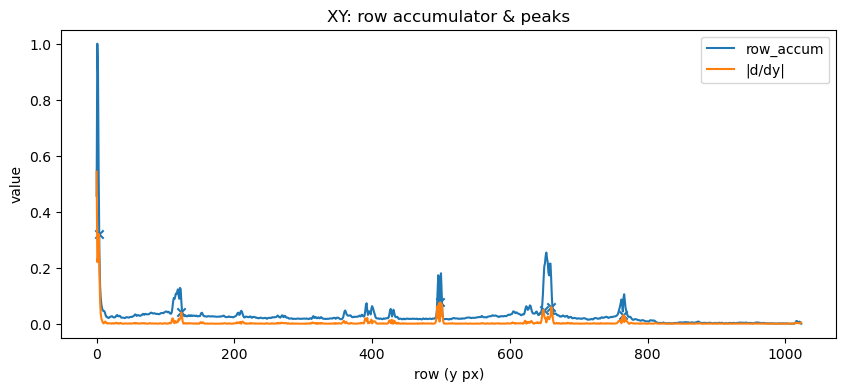

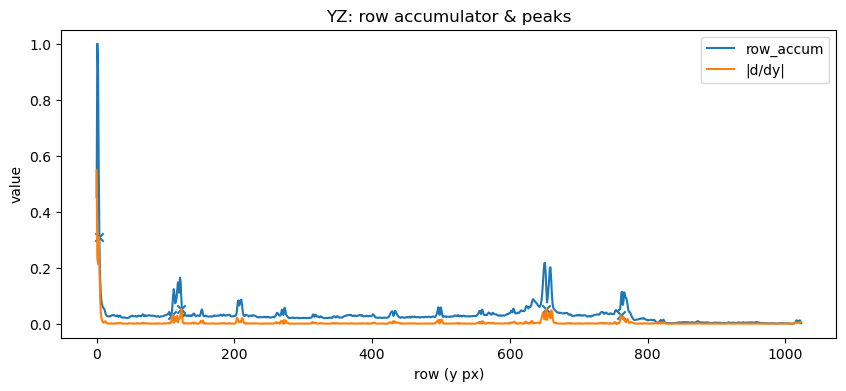

Peaks XY: [  3 123 499 649 660 765] ... total 6
Peaks YZ: [  3 110 123 653 761] ... total 5


In [9]:
# %%
def detect_levels_from_edges(edges: np.ndarray,
                             prominence=0.05, distance=8):
    # Аккумулятор по строкам = сумма откликов (аналог Hough для θ~0)
    row_acc = edges.sum(axis=1)
    row_acc = (row_acc - row_acc.min()) / (np.ptp(row_acc) + 1e-9)
    d = np.abs(np.gradient(row_acc))
    peaks, props = find_peaks(d, prominence=prominence*np.max(d) if d.size else 0.0,
                              distance=distance)
    return row_acc, d, peaks, props

acc_xy, deriv_xy, peaks_xy, props_xy = detect_levels_from_edges(e_xy, PEAK_PROM, PEAK_DIST)
acc_yz, deriv_yz, peaks_yz, props_yz = detect_levels_from_edges(e_yz, PEAK_PROM, PEAK_DIST)

def plot_profile_with_peaks(name, acc, deriv, peaks):
    plt.figure(figsize=(10,4))
    plt.plot(acc, label='row_accum')
    plt.plot(deriv, label='|d/dy|')
    if len(peaks):
        plt.scatter(peaks, deriv[peaks], marker='x')
    plt.title(f'{name}: row accumulator & peaks')
    plt.legend()
    plt.xlabel('row (y px)')
    plt.ylabel('value')
    plt.show()

plot_profile_with_peaks('XY', acc_xy, deriv_xy, peaks_xy)
plot_profile_with_peaks('YZ', acc_yz, deriv_yz, peaks_yz)

print('Peaks XY:', peaks_xy[:20], '... total', len(peaks_xy))
print('Peaks YZ:', peaks_yz[:20], '... total', len(peaks_yz))


## Merge nearby peaks, compute coverage, map to world Y

In [10]:
# %%
@dataclass
class Level:
    y_world: float
    y_px: float
    coverage: float
    score: float
    source: str

def compute_coverage(edges: np.ndarray, y_px: float, band=3, thresh=0.2):
    h, w = edges.shape
    y0 = max(0, int(round(y_px)) - band)
    y1 = min(h, int(round(y_px)) + band + 1)
    band_edges = edges[y0:y1, :]
    if band_edges.size == 0:
        return 0.0
    col_has_edge = (band_edges.max(axis=0) > thresh).astype(np.uint8)
    return float(col_has_edge.mean())

def merge_peaks(peaks: np.ndarray, tol=6):
    if len(peaks) == 0: return []
    peaks = np.sort(peaks)
    groups = [[peaks[0]]]
    for p in peaks[1:]:
        if abs(p - groups[-1][-1]) <= tol:
            groups[-1].append(p)
        else:
            groups.append([p])
    return [int(round(np.mean(g))) for g in groups]

def px_to_world_y(y_px: int, b_edges: np.ndarray):
    y_px = int(np.clip(y_px, 0, len(b_edges)-2))
    return 0.5*(b_edges[y_px] + b_edges[y_px+1])

def build_levels(edges, peaks, b_edges, acc, name):
    merged = merge_peaks(peaks, MERGE_TOL_PX)
    levels = []
    for yp in merged:
        cov = compute_coverage(edges, yp, EDGE_BAND_PX)
        score = float(acc[yp] if 0 <= yp < len(acc) else 0.0) * (0.5 + 0.5*cov)
        yw = px_to_world_y(yp, b_edges)
        levels.append(Level(y_world=yw, y_px=float(yp), coverage=cov, score=score, source=name))
    # фильтр слабых
    if len(levels):
        scores = np.array([lv.score for lv in levels])
        thr = np.median(scores)*0.6
        levels = [lv for lv in levels if (lv.coverage >= MIN_COVERAGE and lv.score >= thr)]
    levels.sort(key=lambda l: l.y_world)
    return levels

levels_xy = build_levels(e_xy, peaks_xy, proj_xy['b_edges'], acc_xy, 'xy')
levels_yz = build_levels(e_yz, peaks_yz, proj_yz['b_edges'], acc_yz, 'yz')

def levels_to_df(levels, label):
    return pd.DataFrame({
        'plane': label,
        'y_world': [lv.y_world for lv in levels],
        'y_px': [lv.y_px for lv in levels],
        'coverage': [lv.coverage for lv in levels],
        'score': [lv.score for lv in levels],
        'source': [lv.source for lv in levels],
    })

df_levels = pd.concat([levels_to_df(levels_xy, 'XY'), levels_to_df(levels_yz, 'YZ')], ignore_index=True)
df_levels_sorted = df_levels.sort_values(['plane', 'y_world']).reset_index(drop=True)
df_levels_sorted


plane   y_world   y_px  coverage     score source
0    XY -0.204646    3.0  1.000000  0.527238     xy
1    XY  0.078689  499.0  0.500977  0.121703     xy
2    XY  0.164375  649.0  0.539551  0.123211     xy
3    XY  0.170659  660.0  0.362305  0.110081     xy
4    YZ -0.204646    3.0  0.973145  0.566169     yz
5    YZ -0.136097  123.0  0.298828  0.058656     yz
6    YZ  0.166660  653.0  0.332031  0.080965     yz

## Overlay detected levels on heatmaps and scatter

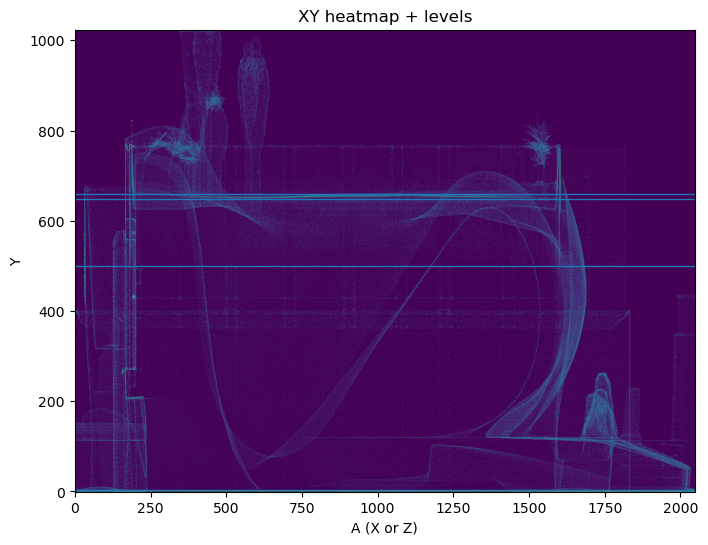

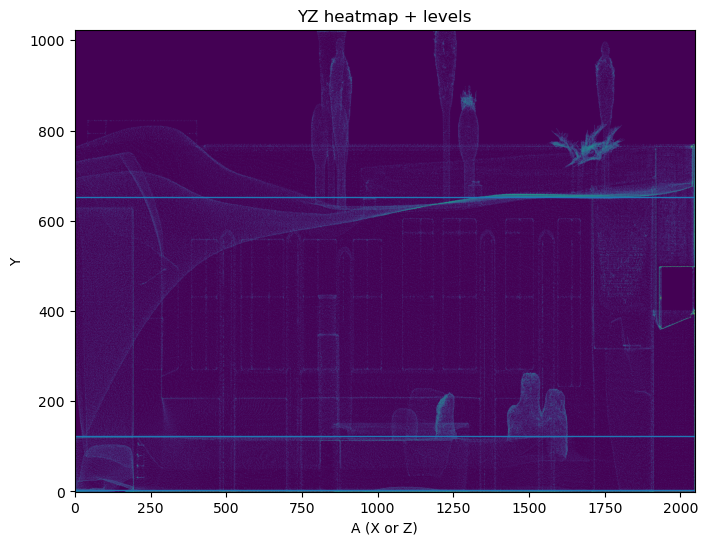

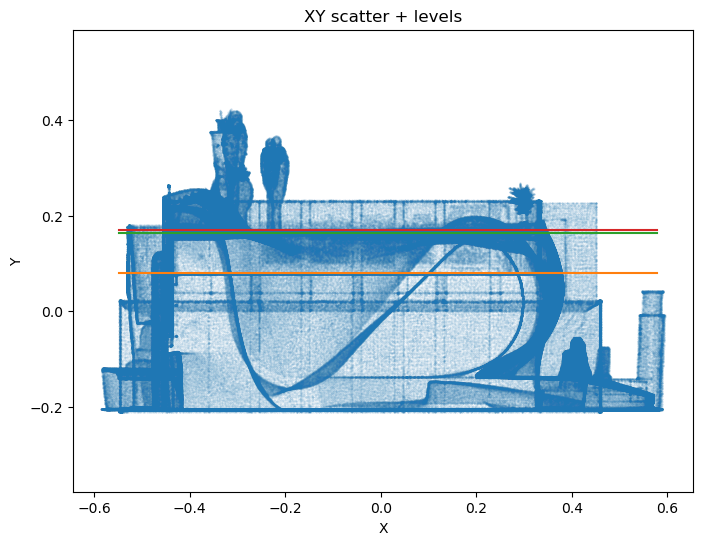

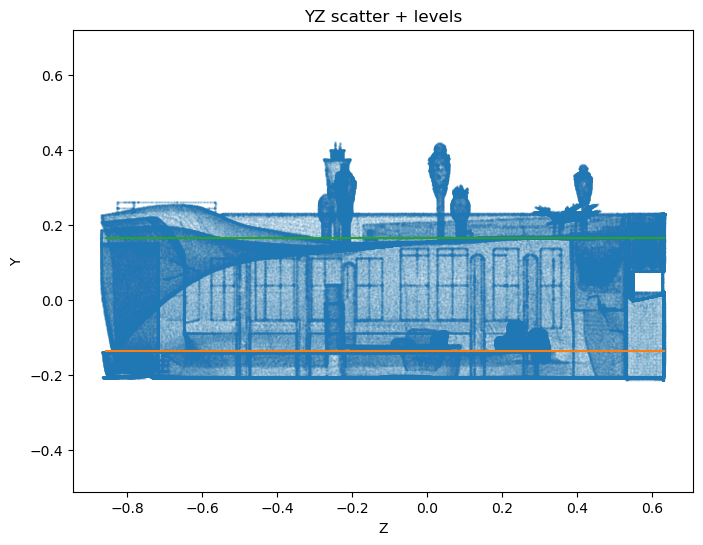

Overlay done.


In [11]:
# %%
def overlay_lines_on_heatmap(P, levels, title='overlay'):
    img = P['img']
    b_edges = P['b_edges']
    plt.figure(figsize=(8,6))
    plt.imshow(img, origin='lower', aspect='auto')
    for lv in levels:
        y = int(round(lv.y_px))
        plt.axhline(y, linewidth=1)
    plt.title(title)
    plt.xlabel('A (X or Z)')
    plt.ylabel('Y')
    plt.show()

def overlay_lines_on_scatter(points, levels, axes=(0,1), title='scatter + levels'):
    A,B = axes
    plt.figure(figsize=(8,6))
    plt.scatter(points[:,A], points[:,B], s=0.2, alpha=0.1)
    for lv in levels:
        y = lv.y_world
        # горизонтальная линия на уровне y
        ymin = y
        # рисуем линию по ширине данных
        a = points[:,A]
        a_min, a_max = np.percentile(a, [0.5, 99.5])
        plt.plot([a_min, a_max], [y, y])
    plt.title(title)
    plt.xlabel(['X','Y','Z'][A])
    plt.ylabel(['X','Y','Z'][B])
    plt.axis('equal')
    plt.show()

overlay_lines_on_heatmap(proj_xy, levels_xy, 'XY heatmap + levels')
overlay_lines_on_heatmap(proj_yz, levels_yz, 'YZ heatmap + levels')

overlay_lines_on_scatter(points, levels_xy, (0,1), 'XY scatter + levels')
overlay_lines_on_scatter(points, levels_yz, (2,1), 'YZ scatter + levels')
print('Overlay done.')


## Save levels to CSV

In [12]:
# %%
out_csv = 'levels_detected.csv'
df_levels_sorted.to_csv(out_csv, index=False)
print('Saved:', os.path.abspath(out_csv))
df_levels_sorted.head(20)


Saved: /Users/dmitry057/Projects/DeepL/archi-ve/FreeCAD/src/Mod/ArchiModule/experiments/levels_detected.csv


plane   y_world   y_px  coverage     score source
0    XY -0.204646    3.0  1.000000  0.527238     xy
1    XY  0.078689  499.0  0.500977  0.121703     xy
2    XY  0.164375  649.0  0.539551  0.123211     xy
3    XY  0.170659  660.0  0.362305  0.110081     xy
4    YZ -0.204646    3.0  0.973145  0.566169     yz
5    YZ -0.136097  123.0  0.298828  0.058656     yz
6    YZ  0.166660  653.0  0.332031  0.080965     yz

## Notes
- Под окна/перемычки можно настраивать `PEAK_PROM`, `MORPH_LEN_PX`, `MIN_COVERAGE`.
- Если фасад сильно разорван по ширине, увеличь `MORPH_LEN_PX` (горизонтальную связность).
- Для наклонённых фасадов перед проекцией можно выровнять здание PCA по XY/ZY.
- Полученные уровни `y_world` используйте для разрезов и последующей план-параметризации.
